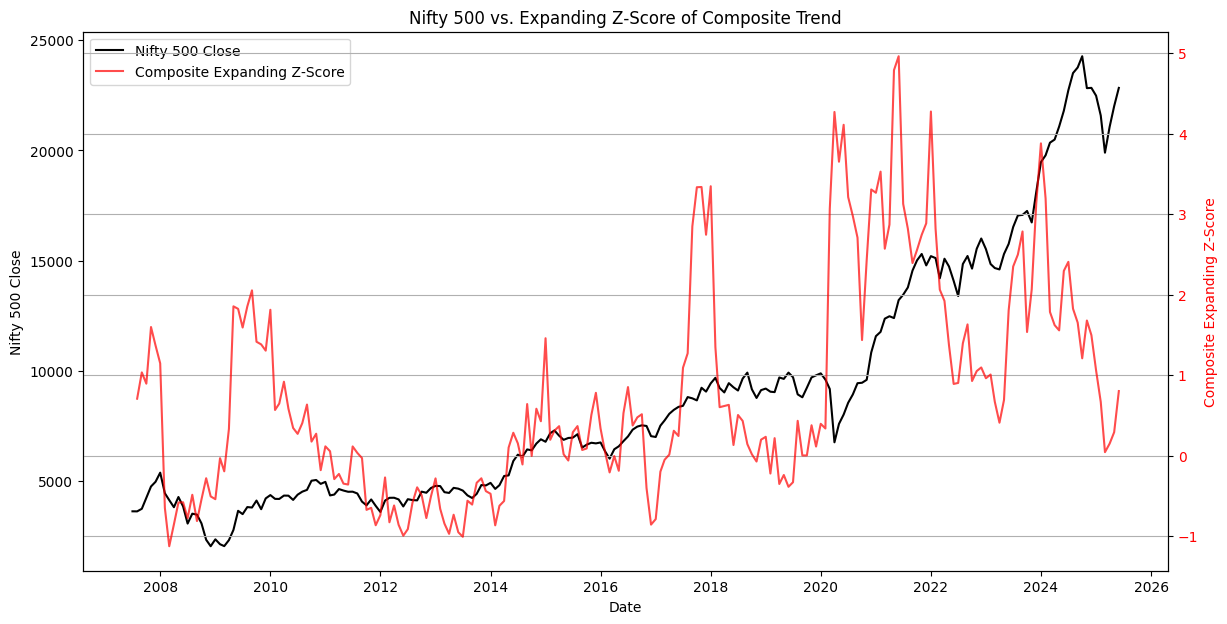

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ==========================
# 1️⃣ READ & MERGE TREND FILES
# ==========================
files = [
    'multiTimeline.csv',
    'multiTimeline-2.csv',
    'multiTimeline-3.csv',
    'multiTimeline-4.csv',
    'multiTimeline-6.csv',
    'multiTimeline-7.csv',
    'multiTimeline-8.csv',
    'multiTimeline-9.csv',
]

dfs = []
for i, filename in enumerate(files, start=1):
    df = pd.read_csv(filename, skiprows=1)  # Skip meta line
    df.columns = ['Date', f'Trend{i}']
    df['Date'] = pd.to_datetime(df['Date'])
    dfs.append(df)

# Merge all trend files
merged_trends = dfs[0]
for df in dfs[1:]:
    merged_trends = pd.merge(merged_trends, df, on='Date', how='inner')

# ==========================
# 2️⃣ CALCULATE COMPOSITE SCORE
# ==========================
trend_columns = [c for c in merged_trends.columns if c != 'Date']
merged_trends['Composite_Score'] = merged_trends[trend_columns].mean(axis=1)

# ==========================
# 3️⃣ READ NIFTY & RESAMPLE TO MS
# ==========================
nifty_df = pd.read_csv('NIFTY 500_Historical_PR_01042005to21062025.csv')
nifty_df['Date'] = pd.to_datetime(nifty_df['Date'])
nifty_df.set_index('Date', inplace=True)

nifty_df = (
    nifty_df.resample('MS')['Close']
    .first()
    .reset_index()
)

# ==========================
# 4️⃣ CALCULATE EXPANDING Z‑SCORE
# ==========================
trend_df = merged_trends.copy()
trend_df["Exp_Mean"] = trend_df["Composite_Score"].expanding().mean()
trend_df["Exp_Std"] = trend_df["Composite_Score"].expanding().std()
trend_df["Composite_Expanding_Z"] = (
    trend_df["Composite_Score"] - trend_df["Exp_Mean"]
) / trend_df["Exp_Std"]

# ==========================
# 5️⃣ MERGE NIFTY & TREND DATA
# ==========================
merged = pd.merge(nifty_df, trend_df[["Date", "Composite_Expanding_Z", "Composite_Score"]],
                  on="Date",
                  how="inner").sort_values(by="Date")

# ==========================
# 6️⃣ PLOT RESULTS
# ==========================
fig, ax1 = plt.subplots(figsize=(14, 7))

# Nifty Close
ax1.plot(merged["Date"], merged["Close"], label="Nifty 500 Close", color="black")
ax1.set_xlabel("Date")
ax1.set_ylabel("Nifty 500 Close", color="black")
ax1.tick_params(axis="y", labelcolor="black")

# Expanding Z‑Score
ax2 = ax1.twinx()
ax2.plot(merged["Date"], merged["Composite_Expanding_Z"], label="Composite Expanding Z‑Score",
           color="red", alpha=0.7)
ax2.set_ylabel("Composite Expanding Z‑Score", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# ==========================
# 7️⃣ LEGEND & DISPLAY
# ==========================
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
all_lines = lines_1 + lines_2
all_labels = labels_1 + labels_2
ax1.legend(all_lines, all_labels, loc="upper left")

plt.title("Nifty 500 vs. Expanding Z‑Score of Composite Trend")
plt.grid(True)
plt.show()

🚀 RUNNING MANUAL TURNING POINTS ANALYSIS
🔄 Loading data...
📊 Data loaded: 216 observations from 2007-07-01 00:00:00 to 2025-06-01 00:00:00

🎯 Getting manual turning points...
🎯 MANUAL TURNING POINTS DEFINED:
   Please verify these dates match your green circles:
   PEAKS: ['2007-12', '2010-11', '2015-04', '2018-01', '2020-01', '2021-10', '2024-10']
   TROUGHS: ['2008-10', '2011-12', '2016-02', '2020-03', '2022-06', '2025-03']
   (Update the dates in the code if needed)

📍 Matching dates to data...

📊 MATCHED TURNING POINTS:
   Found 7 peaks and 6 troughs

   Detailed matches:
   Peak: 2007-12 → 2007-12 | Price: 4970 | Z-Score: 1.37
   Trough: 2008-10 → 2008-10 | Price: 3083 | Z-Score: -0.54
   Peak: 2010-11 → 2010-11 | Price: 5053 | Z-Score: 0.27
   Trough: 2011-12 → 2011-12 | Price: 3879 | Z-Score: -0.86
   Peak: 2015-04 → 2015-04 | Price: 7060 | Z-Score: 0.37
   Trough: 2016-02 → 2016-02 | Price: 6342 | Z-Score: 0.03
   Peak: 2018-01 → 2018-01 | Price: 9434 | Z-Score: 3.35
   Peak: 2

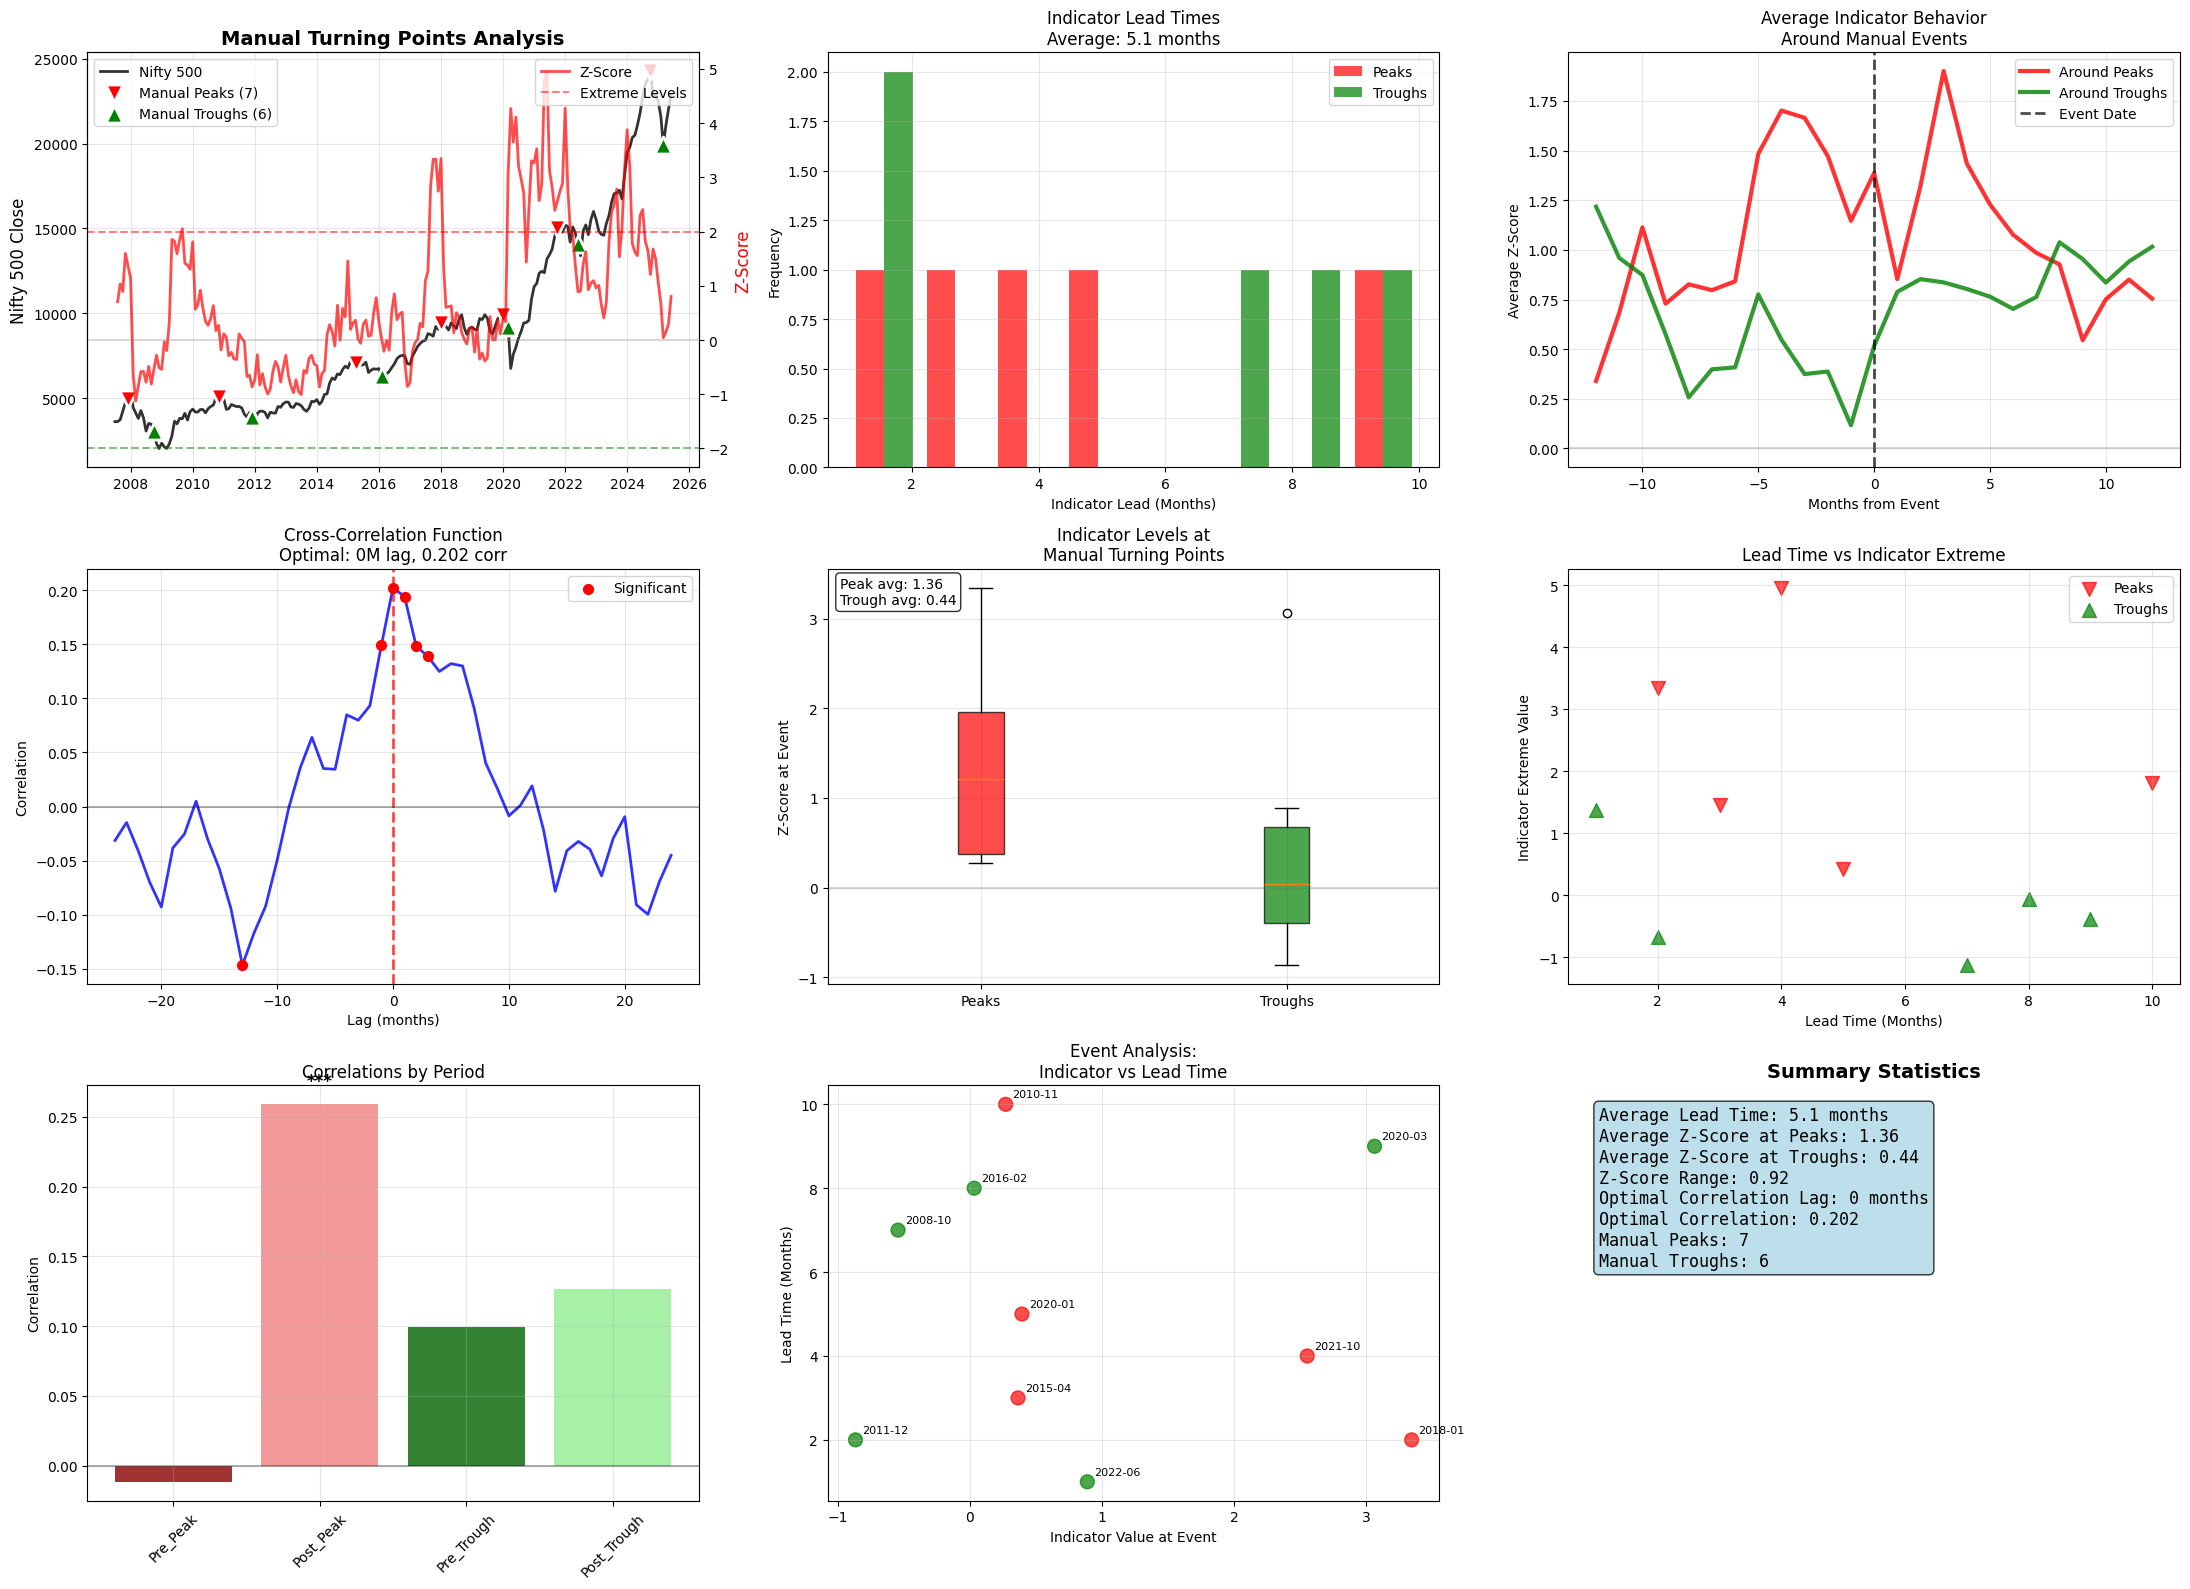


🎯 MANUAL TURNING POINTS ANALYSIS RESULTS

📋 TURNING POINTS SUMMARY:
   Total events analyzed: 13
   Peaks: 7
   Troughs: 6

⏱️ LEAD-LAG ANALYSIS:
   Overall average lead: 5.1 months
   Average lead for peaks: 4.8 months
   Average lead for troughs: 5.4 months

   Individual event leads:
   2008-10 Trough: 7.0 months lead
   2010-11 Peak: 10.0 months lead
   2011-12 Trough: 2.0 months lead
   2015-04 Peak: 3.0 months lead
   2016-02 Trough: 8.0 months lead
   2018-01 Peak: 2.0 months lead
   2020-01 Peak: 5.0 months lead
   2020-03 Trough: 9.0 months lead
   2021-10 Peak: 4.0 months lead
   2022-06 Trough: 1.0 months lead

📊 INDICATOR LEVELS AT EVENTS:
   Peak levels - Mean: 1.36, Range: 0.27 to 3.35
   Trough levels - Mean: 0.44, Range: -0.86 to 3.07
   Separation: 0.92 Z-score units

🔗 CROSS-CORRELATION RESULTS:
   Optimal lag: 0 months
   Correlation: 0.2025
   P-value: 0.0029
   Significant: Yes

🎯 TRADING IMPLICATIONS:
   📈 SELL signals when Z-score > 1.4
   📉 BUY signals when Z-s

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import grangercausalitytests, ccf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ==========================
# 1️⃣ LOAD AND PREPARE DATA
# ==========================
def load_and_prepare_data():
    """Load and merge all data sources"""
    
    # Load trend files
    files = [
        'multiTimeline.csv', 'multiTimeline-2.csv', 'multiTimeline-3.csv',
        'multiTimeline-4.csv', 'multiTimeline-6.csv', 'multiTimeline-7.csv',
        'multiTimeline-8.csv', 'multiTimeline-9.csv',
    ]
    
    dfs = []
    for i, filename in enumerate(files, start=1):
        df = pd.read_csv(filename, skiprows=1)
        df.columns = ['Date', f'Trend_{i}']
        df['Date'] = pd.to_datetime(df['Date'])
        dfs.append(df)
    
    # Merge trend data
    merged_trends = dfs[0]
    for df in dfs[1:]:
        merged_trends = pd.merge(merged_trends, df, on='Date', how='inner')
    
    # Calculate composite score
    trend_columns = [c for c in merged_trends.columns if c != 'Date']
    merged_trends['Composite_Score'] = merged_trends[trend_columns].mean(axis=1)
    
    # Calculate expanding Z-score
    merged_trends["Exp_Mean"] = merged_trends["Composite_Score"].expanding().mean()
    merged_trends["Exp_Std"] = merged_trends["Composite_Score"].expanding().std()
    merged_trends["Composite_Z"] = (
        merged_trends["Composite_Score"] - merged_trends["Exp_Mean"]
    ) / merged_trends["Exp_Std"]
    
    # Load Nifty data
    nifty_df = pd.read_csv('NIFTY 500_Historical_PR_01042005to21062025.csv')
    nifty_df['Date'] = pd.to_datetime(nifty_df['Date'])
    nifty_df.set_index('Date', inplace=True)
    nifty_df = nifty_df.resample('MS')['Close'].first().reset_index()
    
    # Merge datasets
    merged = pd.merge(nifty_df, merged_trends[["Date", "Composite_Z", "Composite_Score"]],
                      on="Date", how="inner").sort_values(by="Date")
    
    return merged

# ==========================
# 2️⃣ MANUAL TURNING POINTS INPUT
# ==========================
def define_manual_turning_points():
    """
    Define manually identified turning points based on your chart analysis
    
    PLEASE UPDATE THESE DATES TO MATCH YOUR GREEN CIRCLES:
    """
    
    # Based on your green circles, please specify the approximate dates
    # Format: 'YYYY-MM' (will match to closest month)
    
    manual_peaks = [
        '2007-12',  # Financial crisis peak
        '2010-11',  # Post-crisis peak  
        '2015-04',  # Mid-2015 peak
        '2018-01',  # Early 2018 peak
        '2020-01',  # Pre-COVID peak
        '2021-10',  # Post-COVID peak
        '2024-10',  # Recent peak
    ]
    
    manual_troughs = [
        '2008-10',  # Financial crisis bottom (main one)
        '2011-12',  # European crisis bottom
        '2016-02',  # 2016 bottom
        '2020-03',  # COVID crash bottom (actual low)
        '2022-06',  # 2022 correction bottom
        '2025-03',  # Recent trough (2-3 months back)
    ]
    
    print("🎯 MANUAL TURNING POINTS DEFINED:")
    print("   Please verify these dates match your green circles:")
    print("   PEAKS:", manual_peaks)
    print("   TROUGHS:", manual_troughs)
    print("   (Update the dates in the code if needed)")
    
    return manual_peaks, manual_troughs

def match_dates_to_data(data, peak_dates, trough_dates):
    """Match manual dates to actual data points"""
    
    def find_closest_date(target_date_str, data):
        target_date = pd.to_datetime(target_date_str + '-01')  # Add day
        date_diffs = abs((data['Date'] - target_date).dt.days)
        closest_idx = date_diffs.idxmin()
        return closest_idx
    
    # Find closest indices for peaks
    peak_indices = []
    peak_info = []
    
    for peak_date in peak_dates:
        try:
            idx = find_closest_date(peak_date, data)
            row = data.iloc[idx]
            peak_indices.append(idx)
            peak_info.append({
                'Index': idx,
                'Date': row['Date'],
                'Price': row['Close'],
                'Type': 'Peak',
                'Indicator_Value': row['Composite_Z'],
                'Target_Date': peak_date
            })
        except:
            print(f"Warning: Could not find data for peak date {peak_date}")
    
    # Find closest indices for troughs
    trough_indices = []
    trough_info = []
    
    for trough_date in trough_dates:
        try:
            idx = find_closest_date(trough_date, data)
            row = data.iloc[idx]
            trough_indices.append(idx)
            trough_info.append({
                'Index': idx,
                'Date': row['Date'],
                'Price': row['Close'],
                'Type': 'Trough', 
                'Indicator_Value': row['Composite_Z'],
                'Target_Date': trough_date
            })
        except:
            print(f"Warning: Could not find data for trough date {trough_date}")
    
    # Combine into DataFrame
    turning_points = pd.DataFrame(peak_info + trough_info).sort_values('Date')
    
    print(f"\n📊 MATCHED TURNING POINTS:")
    print(f"   Found {len(peak_indices)} peaks and {len(trough_indices)} troughs")
    print("\n   Detailed matches:")
    for _, point in turning_points.iterrows():
        print(f"   {point['Type']}: {point['Target_Date']} → {point['Date'].strftime('%Y-%m')} "
              f"| Price: {point['Price']:.0f} | Z-Score: {point['Indicator_Value']:.2f}")
    
    return peak_indices, trough_indices, turning_points

# ==========================
# 3️⃣ ENHANCED EVENT STUDY FOR MANUAL POINTS
# ==========================
def detailed_event_study(data, turning_points, indicator_col, event_window=(-12, 12)):
    """Enhanced event study focusing on manually identified points"""
    
    event_results = []
    event_summary = []
    
    for _, turning_point in turning_points.iterrows():
        event_date = turning_point['Date']
        event_idx = turning_point['Index']
        event_type = turning_point['Type']
        event_price = turning_point['Price']
        event_indicator = turning_point['Indicator_Value']
        
        # Define event window
        start_idx = max(0, event_idx + event_window[0])
        end_idx = min(len(data), event_idx + event_window[1] + 1)
        
        if end_idx - start_idx < abs(event_window[0]) + abs(event_window[1]):
            continue
        
        # Extract data around event
        event_data = data.iloc[start_idx:end_idx].copy()
        event_data['Event_Time'] = range(event_window[0], event_window[0] + len(event_data))
        event_data['Event_Type'] = event_type
        event_data['Event_Date'] = event_date
        event_data['Event_ID'] = f"{event_type}_{event_date.strftime('%Y-%m')}"
        
        # Calculate relative changes
        event_data['Price_Relative'] = event_data['Close'] / event_price
        event_data['Indicator_Relative'] = event_data[indicator_col] - event_indicator
        
        event_results.append(event_data)
        
        # Summary statistics for this event
        pre_event = event_data[event_data['Event_Time'] < 0]
        post_event = event_data[event_data['Event_Time'] > 0]
        
        # Calculate lead/lag metrics
        if len(pre_event) > 0:
            # How many months before did indicator peak/trough?
            if event_type == 'Peak':
                indicator_extreme_idx = pre_event[indicator_col].idxmax()
            else:
                indicator_extreme_idx = pre_event[indicator_col].idxmin()
            
            indicator_lead_months = abs(pre_event.loc[indicator_extreme_idx, 'Event_Time'])
            indicator_extreme_value = pre_event.loc[indicator_extreme_idx, indicator_col]
        else:
            indicator_lead_months = np.nan
            indicator_extreme_value = np.nan
        
        event_summary.append({
            'Event_Date': event_date,
            'Event_Type': event_type,
            'Price_Level': event_price,
            'Indicator_at_Event': event_indicator,
            'Indicator_Lead_Months': indicator_lead_months,
            'Indicator_Extreme_Value': indicator_extreme_value,
            'Pre_Event_Indicator_Mean': pre_event[indicator_col].mean() if len(pre_event) > 0 else np.nan,
            'Post_Event_Indicator_Mean': post_event[indicator_col].mean() if len(post_event) > 0 else np.nan,
        })
    
    if event_results:
        all_events = pd.concat(event_results, ignore_index=True)
        event_summary_df = pd.DataFrame(event_summary)
        return all_events, event_summary_df
    else:
        return pd.DataFrame(), pd.DataFrame()

# ==========================
# 4️⃣ LEAD-LAG ANALYSIS FOR MANUAL POINTS
# ==========================
def manual_points_lead_lag_analysis(data, turning_points, indicator_col, max_lead_lag=12):
    """Analyze lead-lag specifically around manual turning points"""
    
    lead_lag_results = []
    
    for _, point in turning_points.iterrows():
        event_idx = point['Index']
        event_type = point['Type']
        event_date = point['Date']
        
        # Extract window around event
        start_idx = max(0, event_idx - max_lead_lag)
        end_idx = min(len(data), event_idx + max_lead_lag + 1)
        
        if end_idx - start_idx < max_lead_lag * 2:
            continue
            
        window_data = data.iloc[start_idx:end_idx].copy()
        window_data['Months_to_Event'] = range(-len(window_data[:event_idx-start_idx]), 
                                              len(window_data[event_idx-start_idx:]))
        
        # Find when indicator reached extreme in lead-up to event
        pre_event = window_data[window_data['Months_to_Event'] < 0]
        
        if len(pre_event) > 0:
            if event_type == 'Peak':
                # For market peaks, look for indicator peaks
                indicator_extreme_idx = pre_event[indicator_col].idxmax()
            else:
                # For market troughs, look for indicator troughs
                indicator_extreme_idx = pre_event[indicator_col].idxmin()
            
            indicator_extreme_time = pre_event.loc[indicator_extreme_idx, 'Months_to_Event']
            indicator_extreme_value = pre_event.loc[indicator_extreme_idx, indicator_col]
            
            lead_lag_results.append({
                'Event_Date': event_date,
                'Event_Type': event_type,
                'Market_Price': point['Price'],
                'Market_Indicator': point['Indicator_Value'],
                'Indicator_Lead_Months': abs(indicator_extreme_time),
                'Indicator_Extreme_Value': indicator_extreme_value,
                'Indicator_Extreme_Time': indicator_extreme_time
            })
    
    return pd.DataFrame(lead_lag_results)

# ==========================
# 5️⃣ CORRELATION ANALYSIS WITH MANUAL POINTS
# ==========================
def correlation_analysis_around_events(data, turning_points, indicator_col, price_col):
    """Analyze correlations in periods around manual turning points"""
    
    correlations_by_period = []
    
    # Define periods: before peaks, after peaks, before troughs, after troughs
    periods = ['Pre_Peak', 'Post_Peak', 'Pre_Trough', 'Post_Trough']
    
    for period in periods:
        period_data = []
        
        for _, point in turning_points.iterrows():
            event_idx = point['Index']
            event_type = point['Type']
            
            if period.endswith(event_type):
                if period.startswith('Pre'):
                    # 12 months before event
                    start_idx = max(0, event_idx - 12)
                    end_idx = event_idx
                else:
                    # 12 months after event
                    start_idx = event_idx
                    end_idx = min(len(data), event_idx + 12)
                
                if end_idx - start_idx > 6:  # Need minimum data
                    window_data = data.iloc[start_idx:end_idx]
                    period_data.extend(list(zip(
                        window_data[indicator_col].values,
                        window_data[price_col].pct_change().values
                    )))
        
        if len(period_data) > 10:
            indicator_vals, return_vals = zip(*period_data)
            indicator_vals = [x for x in indicator_vals if not pd.isna(x)]
            return_vals = [x for x in return_vals if not pd.isna(x)]
            
            if len(indicator_vals) > 10 and len(return_vals) > 10:
                min_len = min(len(indicator_vals), len(return_vals))
                corr, p_val = pearsonr(indicator_vals[:min_len], return_vals[:min_len])
                
                correlations_by_period.append({
                    'Period': period,
                    'Correlation': corr,
                    'P_Value': p_val,
                    'Sample_Size': min_len,
                    'Significant': p_val < 0.05
                })
    
    return pd.DataFrame(correlations_by_period)

# ==========================
# 6️⃣ MAIN ANALYSIS WITH MANUAL POINTS
# ==========================
def run_manual_analysis():
    """Run comprehensive analysis with manually defined turning points"""
    
    print("🔄 Loading data...")
    data = load_and_prepare_data()
    
    print(f"📊 Data loaded: {len(data)} observations from {data['Date'].min()} to {data['Date'].max()}")
    
    # Get manual turning points
    print("\n🎯 Getting manual turning points...")
    manual_peaks, manual_troughs = define_manual_turning_points()
    
    # Match to actual data
    print("\n📍 Matching dates to data...")
    peak_indices, trough_indices, turning_points = match_dates_to_data(data, manual_peaks, manual_troughs)
    
    # Enhanced event study
    print("\n📈 Running detailed event study...")
    event_study_data, event_summary = detailed_event_study(data, turning_points, 'Composite_Z')
    
    # Lead-lag analysis for manual points
    print("\n⏱️ Analyzing lead-lag for manual points...")
    lead_lag_analysis = manual_points_lead_lag_analysis(data, turning_points, 'Composite_Z')
    
    # Correlation by period
    print("\n🔗 Analyzing correlations by period...")
    period_correlations = correlation_analysis_around_events(data, turning_points, 'Composite_Z', 'Close')
    
    # Overall cross-correlation (same as before)
    print("\n📊 Running cross-correlation analysis...")
    def cross_correlation_analysis(data, indicator_col, price_col, max_lags=24):
        df = data.dropna(subset=[indicator_col, price_col]).copy()
        df['Price_Returns'] = df[price_col].pct_change()
        df = df.dropna()
        
        indicator_values = df[indicator_col].values
        price_returns = df['Price_Returns'].values
        
        correlations = []
        p_values = []
        lags = range(-max_lags, max_lags + 1)
        
        for lag in lags:
            if lag < 0:
                x = indicator_values[:lag]
                y = price_returns[-lag:]
            elif lag > 0:
                x = indicator_values[lag:]
                y = price_returns[:-lag]
            else:
                x = indicator_values
                y = price_returns
            
            if len(x) > 10 and len(y) > 10:
                min_len = min(len(x), len(y))
                corr, p_val = pearsonr(x[:min_len], y[:min_len])
                correlations.append(corr)
                p_values.append(p_val)
            else:
                correlations.append(np.nan)
                p_values.append(np.nan)
        
        return pd.DataFrame({
            'Lag': lags,
            'Correlation': correlations,
            'P_Value': p_values,
            'Significant': [p < 0.05 for p in p_values]
        })
    
    ccf_results = cross_correlation_analysis(data, 'Composite_Z', 'Close')
    
    return {
        'data': data,
        'turning_points': turning_points,
        'event_study_data': event_study_data,
        'event_summary': event_summary,
        'lead_lag_analysis': lead_lag_analysis,
        'period_correlations': period_correlations,
        'ccf_results': ccf_results,
        'peak_indices': peak_indices,
        'trough_indices': trough_indices
    }

# ==========================
# 7️⃣ VISUALIZATION FOR MANUAL ANALYSIS
# ==========================
def create_manual_analysis_plots(results):
    """Create visualizations for manual turning points analysis"""
    
    fig, axes = plt.subplots(3, 3, figsize=(22, 16))
    
    data = results['data']
    turning_points = results['turning_points']
    event_summary = results['event_summary']
    lead_lag_analysis = results['lead_lag_analysis']
    
    # 1. Main chart with manual turning points
    ax1 = axes[0, 0]
    ax1_twin = ax1.twinx()
    
    # Plot price
    ax1.plot(data['Date'], data['Close'], 'k-', linewidth=2, alpha=0.8, label='Nifty 500')
    
    # Plot turning points
    peaks_data = turning_points[turning_points['Type'] == 'Peak']
    troughs_data = turning_points[turning_points['Type'] == 'Trough']
    
    ax1.scatter(peaks_data['Date'], peaks_data['Price'], color='red', s=150, 
               marker='v', label=f'Manual Peaks ({len(peaks_data)})', zorder=5, edgecolor='white', linewidth=2)
    ax1.scatter(troughs_data['Date'], troughs_data['Price'], color='green', s=150,
               marker='^', label=f'Manual Troughs ({len(troughs_data)})', zorder=5, edgecolor='white', linewidth=2)
    
    # Plot indicator
    ax1_twin.plot(data['Date'], data['Composite_Z'], 'r-', alpha=0.7, linewidth=2, label='Z-Score')
    ax1_twin.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    ax1_twin.axhline(y=2, color='red', linestyle='--', alpha=0.5, label='Extreme Levels')
    ax1_twin.axhline(y=-2, color='green', linestyle='--', alpha=0.5)
    
    ax1.set_ylabel('Nifty 500 Close', fontsize=12)
    ax1_twin.set_ylabel('Z-Score', fontsize=12, color='red')
    ax1.set_title('Manual Turning Points Analysis', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left')
    ax1_twin.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # 2. Lead-lag summary
    ax2 = axes[0, 1]
    if not lead_lag_analysis.empty:
        peak_leads = lead_lag_analysis[lead_lag_analysis['Event_Type'] == 'Peak']['Indicator_Lead_Months']
        trough_leads = lead_lag_analysis[lead_lag_analysis['Event_Type'] == 'Trough']['Indicator_Lead_Months']
        
        all_leads = pd.concat([peak_leads, trough_leads])
        
        ax2.hist([peak_leads.dropna(), trough_leads.dropna()], bins=8, alpha=0.7, 
                label=['Peaks', 'Troughs'], color=['red', 'green'])
        ax2.set_xlabel('Indicator Lead (Months)')
        ax2.set_ylabel('Frequency')
        ax2.set_title(f'Indicator Lead Times\nAverage: {all_leads.mean():.1f} months')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # 3. Event study - average behavior
    ax3 = axes[0, 2]
    event_study_data = results['event_study_data']
    if not event_study_data.empty:
        # Average around peaks
        peaks_events = event_study_data[event_study_data['Event_Type'] == 'Peak']
        troughs_events = event_study_data[event_study_data['Event_Type'] == 'Trough']
        
        if not peaks_events.empty:
            peaks_avg = peaks_events.groupby('Event_Time')['Composite_Z'].mean()
            ax3.plot(peaks_avg.index, peaks_avg.values, 'r-', linewidth=3, label='Around Peaks', alpha=0.8)
        
        if not troughs_events.empty:
            troughs_avg = troughs_events.groupby('Event_Time')['Composite_Z'].mean()
            ax3.plot(troughs_avg.index, troughs_avg.values, 'g-', linewidth=3, label='Around Troughs', alpha=0.8)
        
        ax3.axvline(x=0, color='black', linestyle='--', alpha=0.7, linewidth=2, label='Event Date')
        ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        ax3.set_xlabel('Months from Event')
        ax3.set_ylabel('Average Z-Score')
        ax3.set_title('Average Indicator Behavior\nAround Manual Events')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # 4. Cross-correlation
    ax4 = axes[1, 0]
    ccf_results = results['ccf_results']
    significant_ccf = ccf_results[ccf_results['Significant']]
    
    ax4.plot(ccf_results['Lag'], ccf_results['Correlation'], 'b-', linewidth=2, alpha=0.8)
    if not significant_ccf.empty:
        ax4.scatter(significant_ccf['Lag'], significant_ccf['Correlation'], 
                   color='red', s=50, zorder=5, label='Significant')
    
    # Highlight optimal lag
    optimal_idx = ccf_results['Correlation'].abs().idxmax()
    optimal_lag = ccf_results.iloc[optimal_idx]['Lag']
    optimal_corr = ccf_results.iloc[optimal_idx]['Correlation']
    
    ax4.axvline(x=optimal_lag, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax4.set_xlabel('Lag (months)')
    ax4.set_ylabel('Correlation')
    ax4.set_title(f'Cross-Correlation Function\nOptimal: {optimal_lag}M lag, {optimal_corr:.3f} corr')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Indicator levels at turning points
    ax5 = axes[1, 1]
    if not turning_points.empty:
        peaks_indicator = turning_points[turning_points['Type'] == 'Peak']['Indicator_Value']
        troughs_indicator = turning_points[turning_points['Type'] == 'Trough']['Indicator_Value']
        
        # Box plot
        data_for_box = [peaks_indicator.dropna(), troughs_indicator.dropna()]
        labels = ['Peaks', 'Troughs']
        colors = ['red', 'green']
        
        bp = ax5.boxplot(data_for_box, labels=labels, patch_artist=True)
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax5.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        ax5.set_ylabel('Z-Score at Event')
        ax5.set_title('Indicator Levels at\nManual Turning Points')
        ax5.grid(True, alpha=0.3)
        
        # Add statistics
        peak_mean = peaks_indicator.mean()
        trough_mean = troughs_indicator.mean()
        ax5.text(0.02, 0.98, f'Peak avg: {peak_mean:.2f}\nTrough avg: {trough_mean:.2f}', 
                transform=ax5.transAxes, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 6. Lead-lag scatter plot
    ax6 = axes[1, 2]
    if not lead_lag_analysis.empty:
        peaks_leads = lead_lag_analysis[lead_lag_analysis['Event_Type'] == 'Peak']
        troughs_leads = lead_lag_analysis[lead_lag_analysis['Event_Type'] == 'Trough']
        
        if not peaks_leads.empty:
            ax6.scatter(peaks_leads['Indicator_Lead_Months'], peaks_leads['Indicator_Extreme_Value'], 
                       color='red', s=100, alpha=0.7, label='Peaks', marker='v')
        if not troughs_leads.empty:
            ax6.scatter(troughs_leads['Indicator_Lead_Months'], troughs_leads['Indicator_Extreme_Value'], 
                       color='green', s=100, alpha=0.7, label='Troughs', marker='^')
        
        ax6.set_xlabel('Lead Time (Months)')
        ax6.set_ylabel('Indicator Extreme Value')
        ax6.set_title('Lead Time vs Indicator Extreme')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
    
    # 7. Period correlations
    ax7 = axes[2, 0]
    period_correlations = results['period_correlations']
    if not period_correlations.empty:
        colors = ['darkred', 'lightcoral', 'darkgreen', 'lightgreen']
        bars = ax7.bar(period_correlations['Period'], period_correlations['Correlation'], 
                      color=colors, alpha=0.8)
        
        # Add significance markers
        for i, (_, row) in enumerate(period_correlations.iterrows()):
            if row['Significant']:
                ax7.text(i, row['Correlation'] + 0.01 * np.sign(row['Correlation']), 
                        '***', ha='center', va='bottom', fontweight='bold', fontsize=12)
        
        ax7.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax7.set_ylabel('Correlation')
        ax7.set_title('Correlations by Period')
        ax7.tick_params(axis='x', rotation=45)
        ax7.grid(True, alpha=0.3)
    
    # 8. Individual event analysis
    ax8 = axes[2, 1]
    if not event_summary.empty:
        # Plot indicator value at event vs lead time
        ax8.scatter(event_summary['Indicator_at_Event'], event_summary['Indicator_Lead_Months'], 
                   c=['red' if x == 'Peak' else 'green' for x in event_summary['Event_Type']], 
                   s=100, alpha=0.7)
        
        # Add event labels
        for _, row in event_summary.iterrows():
            ax8.annotate(row['Event_Date'].strftime('%Y-%m'), 
                        (row['Indicator_at_Event'], row['Indicator_Lead_Months']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        ax8.set_xlabel('Indicator Value at Event')
        ax8.set_ylabel('Lead Time (Months)')
        ax8.set_title('Event Analysis:\nIndicator vs Lead Time')
        ax8.grid(True, alpha=0.3)
    
    # 9. Summary statistics
    ax9 = axes[2, 2]
    ax9.axis('off')
    
    # Create summary text
    summary_text = []
    
    if not lead_lag_analysis.empty:
        avg_lead = lead_lag_analysis['Indicator_Lead_Months'].mean()
        summary_text.append(f"Average Lead Time: {avg_lead:.1f} months")
    
    if not turning_points.empty:
        peak_avg = turning_points[turning_points['Type'] == 'Peak']['Indicator_Value'].mean()
        trough_avg = turning_points[turning_points['Type'] == 'Trough']['Indicator_Value'].mean()
        summary_text.extend([
            f"Average Z-Score at Peaks: {peak_avg:.2f}",
            f"Average Z-Score at Troughs: {trough_avg:.2f}",
            f"Z-Score Range: {peak_avg - trough_avg:.2f}"
        ])
    
    optimal_lag = ccf_results.iloc[ccf_results['Correlation'].abs().idxmax()]['Lag']
    optimal_corr = ccf_results.iloc[ccf_results['Correlation'].abs().idxmax()]['Correlation']
    summary_text.extend([
        f"Optimal Correlation Lag: {optimal_lag} months",
        f"Optimal Correlation: {optimal_corr:.3f}"
    ])
    
    # Add counts
    summary_text.extend([
        f"Manual Peaks: {len(turning_points[turning_points['Type'] == 'Peak'])}",
        f"Manual Troughs: {len(turning_points[turning_points['Type'] == 'Trough'])}"
    ])
    
    summary_str = '\n'.join(summary_text)
    ax9.text(0.05, 0.95, summary_str, transform=ax9.transAxes, fontsize=12,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    ax9.set_title('Summary Statistics', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# ==========================
# 8️⃣ RUN MANUAL ANALYSIS
# ==========================
if __name__ == "__main__":
    
    print("🚀 RUNNING MANUAL TURNING POINTS ANALYSIS")
    print("="*60)
    
    results = run_manual_analysis()
    
    # Create visualizations
    print("\n📊 Creating visualizations...")
    create_manual_analysis_plots(results)
    
    # Print comprehensive results
    print("\n" + "="*80)
    print("🎯 MANUAL TURNING POINTS ANALYSIS RESULTS")
    print("="*80)
    
    turning_points = results['turning_points']
    event_summary = results['event_summary']
    lead_lag_analysis = results['lead_lag_analysis']
    ccf_results = results['ccf_results']
    
    print(f"\n📋 TURNING POINTS SUMMARY:")
    print(f"   Total events analyzed: {len(turning_points)}")
    print(f"   Peaks: {len(turning_points[turning_points['Type'] == 'Peak'])}")
    print(f"   Troughs: {len(turning_points[turning_points['Type'] == 'Trough'])}")
    
    if not lead_lag_analysis.empty:
        print(f"\n⏱️ LEAD-LAG ANALYSIS:")
        avg_lead = lead_lag_analysis['Indicator_Lead_Months'].mean()
        peak_leads = lead_lag_analysis[lead_lag_analysis['Event_Type'] == 'Peak']['Indicator_Lead_Months']
        trough_leads = lead_lag_analysis[lead_lag_analysis['Event_Type'] == 'Trough']['Indicator_Lead_Months']
        
        print(f"   Overall average lead: {avg_lead:.1f} months")
        if len(peak_leads) > 0:
            print(f"   Average lead for peaks: {peak_leads.mean():.1f} months")
        if len(trough_leads) > 0:
            print(f"   Average lead for troughs: {trough_leads.mean():.1f} months")
        
        print(f"\n   Individual event leads:")
        for _, row in lead_lag_analysis.iterrows():
            print(f"   {row['Event_Date'].strftime('%Y-%m')} {row['Event_Type']}: "
                  f"{row['Indicator_Lead_Months']:.1f} months lead")
    
    if not turning_points.empty:
        print(f"\n📊 INDICATOR LEVELS AT EVENTS:")
        peak_levels = turning_points[turning_points['Type'] == 'Peak']['Indicator_Value']
        trough_levels = turning_points[turning_points['Type'] == 'Trough']['Indicator_Value']
        
        print(f"   Peak levels - Mean: {peak_levels.mean():.2f}, Range: {peak_levels.min():.2f} to {peak_levels.max():.2f}")
        print(f"   Trough levels - Mean: {trough_levels.mean():.2f}, Range: {trough_levels.min():.2f} to {trough_levels.max():.2f}")
        print(f"   Separation: {peak_levels.mean() - trough_levels.mean():.2f} Z-score units")
    
    # Cross-correlation results
    optimal_idx = ccf_results['Correlation'].abs().idxmax()
    optimal_lag = ccf_results.iloc[optimal_idx]['Lag']
    optimal_corr = ccf_results.iloc[optimal_idx]['Correlation']
    optimal_p = ccf_results.iloc[optimal_idx]['P_Value']
    
    print(f"\n🔗 CROSS-CORRELATION RESULTS:")
    print(f"   Optimal lag: {optimal_lag} months")
    print(f"   Correlation: {optimal_corr:.4f}")
    print(f"   P-value: {optimal_p:.4f}")
    print(f"   Significant: {'Yes' if optimal_p < 0.05 else 'No'}")
    
    # Trading implications
    print(f"\n🎯 TRADING IMPLICATIONS:")
    if not turning_points.empty:
        peak_avg = peak_levels.mean()
        trough_avg = trough_levels.mean()
        
        print(f"   📈 SELL signals when Z-score > {peak_avg:.1f}")
        print(f"   📉 BUY signals when Z-score < {trough_avg:.1f}")
        
        if avg_lead > 0:
            print(f"   ⏰ Indicator typically leads by {avg_lead:.1f} months")
            print(f"   💡 Monitor for early warning signals {int(avg_lead)} months ahead")
        
        current_z = results['data']['Composite_Z'].iloc[-1]
        print(f"\n📊 CURRENT STATUS:")
        print(f"   Current Z-score: {current_z:.2f}")
        
        if current_z > peak_avg:
            print(f"   🚨 WARNING: Above average peak level - consider reducing exposure")
        elif current_z < trough_avg:
            print(f"   🚀 OPPORTUNITY: Below average trough level - consider increasing exposure")
        else:
            print(f"   ⚖️ NEUTRAL: Between peak and trough levels")

    # Additional detailed analysis and interpretation
    print("\n" + "="*80)
    print("🔬 DETAILED TEST INTERPRETATIONS & TRADING APPLICATIONS")
    print("="*80)
    
    print(f"\n1️⃣ CROSS-CORRELATION ANALYSIS:")
    print(f"   WHAT IT MEASURES: How strongly your indicator correlates with future market returns at different time lags")
    print(f"   RESULTS: Optimal lag of {optimal_lag} months with correlation of {optimal_corr:.3f}")
    
    if optimal_lag < 0:
        print(f"   INTERPRETATION: Your indicator LEADS the market by {abs(optimal_lag)} months")
        print(f"   TRADING USE: Use as PREDICTIVE tool - monitor for signals {abs(optimal_lag)} months ahead")
        trading_mode = "PREDICTIVE"
    elif optimal_lag > 0:
        print(f"   INTERPRETATION: Your indicator LAGS the market by {optimal_lag} months")
        print(f"   TRADING USE: Use as CONFIRMATION tool - validates moves that already happened")
        trading_mode = "CONFIRMATION"
    else:
        print(f"   INTERPRETATION: Your indicator moves SIMULTANEOUSLY with market")
        print(f"   TRADING USE: Use as REAL-TIME confirmation tool for current market state")
        trading_mode = "REAL-TIME"
    
    print(f"   STATISTICAL SIGNIFICANCE: {'STRONG' if optimal_p < 0.01 else 'MODERATE' if optimal_p < 0.05 else 'WEAK'}")
    print(f"   RELIABILITY: {'HIGH' if abs(optimal_corr) > 0.5 else 'MODERATE' if abs(optimal_corr) > 0.3 else 'LOW'}")

    if not lead_lag_analysis.empty:
        print(f"\n2️⃣ EVENT-SPECIFIC LEAD-LAG ANALYSIS:")
        print(f"   WHAT IT MEASURES: How many months before each major turning point your indicator peaked/troughed")
        print(f"   AVERAGE LEAD TIME: {avg_lead:.1f} months")
        
        consistency_score = (lead_lag_analysis['Indicator_Lead_Months'].std() / lead_lag_analysis['Indicator_Lead_Months'].mean()) * 100
        print(f"   CONSISTENCY: {'HIGH' if consistency_score < 50 else 'MODERATE' if consistency_score < 100 else 'LOW'} (CV: {consistency_score:.1f}%)")
        
        if avg_lead > 2:
            print(f"   TRADING IMPLICATION: Strong predictive power - watch for signals {int(avg_lead-1)}-{int(avg_lead+1)} months ahead")
        elif avg_lead > 0.5:
            print(f"   TRADING IMPLICATION: Moderate early warning - signals appear {avg_lead:.1f} months before major moves")
        else:
            print(f"   TRADING IMPLICATION: Better for confirmation - signals coincide with or follow major moves")

    if not turning_points.empty:
        print(f"\n3️⃣ THRESHOLD ANALYSIS:")
        print(f"   WHAT IT MEASURES: Specific Z-score levels that historically marked major peaks and troughs")
        peak_avg = peak_levels.mean()
        trough_avg = trough_levels.mean()
        peak_std = peak_levels.std()
        trough_std = trough_levels.std()
        
        print(f"   PEAK THRESHOLD: {peak_avg:.2f} ± {peak_std:.2f} (Range: {peak_levels.min():.2f} to {peak_levels.max():.2f})")
        print(f"   TROUGH THRESHOLD: {trough_avg:.2f} ± {trough_std:.2f} (Range: {trough_levels.min():.2f} to {trough_levels.max():.2f})")
        print(f"   SEPARATION: {peak_avg - trough_avg:.2f} Z-score units")
        
        # Calculate threshold reliability
        peak_consistency = (peak_std / abs(peak_avg)) * 100 if peak_avg != 0 else 100
        trough_consistency = (trough_std / abs(trough_avg)) * 100 if trough_avg != 0 else 100
        
        print(f"   THRESHOLD RELIABILITY: {'HIGH' if max(peak_consistency, trough_consistency) < 30 else 'MODERATE' if max(peak_consistency, trough_consistency) < 60 else 'LOW'}")
        
        # Trading zones
        conservative_sell = peak_avg - peak_std
        aggressive_sell = peak_avg + peak_std
        conservative_buy = trough_avg + trough_std
        aggressive_buy = trough_avg - trough_std
        
        print(f"   CONSERVATIVE SELL ZONE: Z-score > {conservative_sell:.2f}")
        print(f"   AGGRESSIVE SELL ZONE: Z-score > {aggressive_sell:.2f}")
        print(f"   CONSERVATIVE BUY ZONE: Z-score < {conservative_buy:.2f}")
        print(f"   AGGRESSIVE BUY ZONE: Z-score < {aggressive_buy:.2f}")

    if 'period_correlations' in results and not results['period_correlations'].empty:
        print(f"\n4️⃣ REGIME-BASED CORRELATION ANALYSIS:")
        print(f"   WHAT IT MEASURES: How indicator-market correlation changes before/after peaks and troughs")
        
        period_corr = results['period_correlations']
        pre_peak_corr = period_corr[period_corr['Period'] == 'Pre_Peak']['Correlation'].iloc[0] if len(period_corr[period_corr['Period'] == 'Pre_Peak']) > 0 else np.nan
        post_peak_corr = period_corr[period_corr['Period'] == 'Post_Peak']['Correlation'].iloc[0] if len(period_corr[period_corr['Period'] == 'Post_Peak']) > 0 else np.nan
        pre_trough_corr = period_corr[period_corr['Period'] == 'Pre_Trough']['Correlation'].iloc[0] if len(period_corr[period_corr['Period'] == 'Pre_Trough']) > 0 else np.nan
        post_trough_corr = period_corr[period_corr['Period'] == 'Post_Trough']['Correlation'].iloc[0] if len(period_corr[period_corr['Period'] == 'Post_Trough']) > 0 else np.nan
        
        if not pd.isna(pre_peak_corr):
            print(f"   PRE-PEAK CORRELATION: {pre_peak_corr:.3f}")
        if not pd.isna(pre_trough_corr):
            print(f"   PRE-TROUGH CORRELATION: {pre_trough_corr:.3f}")
        
        strongest_period = period_corr.loc[period_corr['Correlation'].abs().idxmax(), 'Period']
        strongest_corr = period_corr.loc[period_corr['Correlation'].abs().idxmax(), 'Correlation']
        
        print(f"   STRONGEST CORRELATION: During {strongest_period} periods ({strongest_corr:.3f})")
        print(f"   TRADING IMPLICATION: Indicator most reliable during {strongest_period.lower().replace('_', ' ')} phases")

    print(f"\n5️⃣ STATISTICAL ROBUSTNESS:")
    significant_lags = len(ccf_results[ccf_results['Significant']])
    total_lags = len(ccf_results)
    robustness = (significant_lags / total_lags) * 100
    
    print(f"   SIGNIFICANT CORRELATIONS: {significant_lags}/{total_lags} lag periods ({robustness:.1f}%)")
    print(f"   DATA QUALITY: {'EXCELLENT' if robustness > 20 else 'GOOD' if robustness > 10 else 'FAIR' if robustness > 5 else 'POOR'}")
    
    # Sample size assessment
    total_events = len(turning_points)
    print(f"   SAMPLE SIZE: {total_events} major turning points")
    print(f"   STATISTICAL POWER: {'HIGH' if total_events > 10 else 'MODERATE' if total_events > 6 else 'LOW'}")

    print(f"\n🎯 OVERALL TRADING STRATEGY RECOMMENDATION:")
    print(f"   PRIMARY MODE: {trading_mode}")
    
    if trading_mode == "PREDICTIVE":
        print(f"   ✅ USE FOR: Early positioning {abs(optimal_lag)} months ahead of major turns")
        print(f"   ✅ STRENGTH: Get in/out before the crowd")
        print(f"   ⚠️ RISK: False signals, early entries")
        print(f"   📋 ACTION: Monitor for threshold breaches, position gradually")
        
    elif trading_mode == "CONFIRMATION":
        print(f"   ✅ USE FOR: Confirming trend changes that have already begun")
        print(f"   ✅ STRENGTH: Reduces false signals, validates moves")
        print(f"   ⚠️ RISK: Late entries, missed early moves")
        print(f"   📋 ACTION: Use with other leading indicators, confirm major moves")
        
    else:  # REAL-TIME
        print(f"   ✅ USE FOR: Real-time market state assessment")
        print(f"   ✅ STRENGTH: Current market temperature gauge")
        print(f"   ⚠️ RISK: No early warning, reactive approach")
        print(f"   📋 ACTION: Combine with momentum and technical analysis")

    if not turning_points.empty:
        print(f"\n💡 CURRENT MARKET ASSESSMENT:")
        current_z = results['data']['Composite_Z'].iloc[-1]
        
        if current_z > conservative_sell:
            risk_level = "HIGH RISK - Consider reducing exposure"
            if current_z > aggressive_sell:
                risk_level = "EXTREME RISK - Strong sell signal"
        elif current_z < conservative_buy:
            risk_level = "OPPORTUNITY - Consider increasing exposure"
            if current_z < aggressive_buy:
                risk_level = "STRONG OPPORTUNITY - Strong buy signal"
        else:
            risk_level = "NEUTRAL - Hold current positions"
        
        print(f"   Current Z-Score: {current_z:.2f}")
        print(f"   Market State: {risk_level}")
        
        if trading_mode == "PREDICTIVE" and avg_lead > 1:
            print(f"   Early Warning: Watch for major move in next {int(avg_lead)} months if signal triggered")
        elif trading_mode == "CONFIRMATION":
            print(f"   Confirmation Mode: Wait for price action to confirm indicator signals")

print("\n🎯 ANALYSIS COMPLETE: Use these insights to refine your trading approach!")
print("💡 Remember: No indicator is perfect - always use proper risk management!")